# 4. Assignment (Linear and logistic regression)

## 4.1 Objectives

The objectives of this assignment are:

1. To learn to use linear regression for predicting continuously varying target variables
2. To learn to use logistic regression for binary classification
3. To learn to estimate the relative importance of input features

## 4.2 Data understanding

In [34]:
import pandas as pd
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
real_estate_valuation = fetch_ucirepo(id=477) 
  
# data (as pandas dataframes) 
X = real_estate_valuation.data.features 
y = real_estate_valuation.data.targets 
  
# metadata 
print(real_estate_valuation.metadata) 
  
# variable information 
print(real_estate_valuation.variables) 

df_x = pd.DataFrame(X)
df_y = pd.DataFrame(y)
df_combined = pd.concat([df_x, df_y], axis=1)


{'uci_id': 477, 'name': 'Real Estate Valuation', 'repository_url': 'https://archive.ics.uci.edu/dataset/477/real+estate+valuation+data+set', 'data_url': 'https://archive.ics.uci.edu/static/public/477/data.csv', 'abstract': 'The real estate valuation is a regression problem. The market historical data set of real estate valuation are collected from Sindian Dist., New Taipei City, Taiwan. ', 'area': 'Business', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 414, 'num_features': 6, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': ['Y house price of unit area'], 'index_col': ['No'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2018, 'last_updated': 'Mon Feb 26 2024', 'dataset_doi': '10.24432/C5J30W', 'creators': ['I-Cheng Yeh'], 'intro_paper': {'title': 'Building real estate valuation models with comparative approach through case-based reasoning', 'authors': 'I. Yeh, Tzu-Kuang Hsu', 'published_

In [35]:
df_combined

,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1
...,...,...,...,...,...,...,...
409,2013.000,13.7,4082.01500,0,24.94155,121.50381,15.4
410,2012.667,5.6,90.45606,9,24.97433,121.54310,50.0
411,2013.250,18.8,390.96960,7,24.97923,121.53986,40.6
412,2013.000,8.1,104.81010,5,24.96674,121.54067,52.5


In [36]:
df_combined.describe(include='all')

,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,2013.148971,17.712560,1083.885689,4.094203,24.969030,121.533361,37.980193
std,0.281967,11.392485,1262.109595,2.945562,0.012410,0.015347,13.606488
min,2012.667000,0.000000,23.382840,0.000000,24.932070,121.473530,7.600000
25%,2012.917000,9.025000,289.324800,1.000000,24.963000,121.528085,27.700000
50%,2013.167000,16.100000,492.231300,4.000000,24.971100,121.538630,38.450000
75%,2013.417000,28.150000,1454.279000,6.000000,24.977455,121.543305,46.600000
max,2013.583000,43.800000,6488.021000,10.000000,25.014590,121.566270,117.500000


In [37]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 7 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   X1 transaction date                     414 non-null    float64
 1   X2 house age                            414 non-null    float64
 2   X3 distance to the nearest MRT station  414 non-null    float64
 3   X4 number of convenience stores         414 non-null    int64  
 4   X5 latitude                             414 non-null    float64
 5   X6 longitude                            414 non-null    float64
 6   Y house price of unit area              414 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 22.8 KB


The dataset contains 414 records and 8 columns.There are no data with missing values.  
Structure of the data:

- `No`: Record number.
- `X1 transaction date`: Transaction date (in year and fraction of a month format).
- `2 house age: Age of the house in years`.
- `X3 distance to the nearest MRT station`: Distance to the nearest MRT station (in meters).
- `X4 number of convenience stores`: Number of stores in the neighborhood.
- `X5 latitude`: Latitude of the property location.
- `X6 longitude`: Longitude of the property location.
- `Y house price of unit area` : The price of the property per unit area (target variable).

## 4.3 Data preparation

First, let's see what the data set looks like

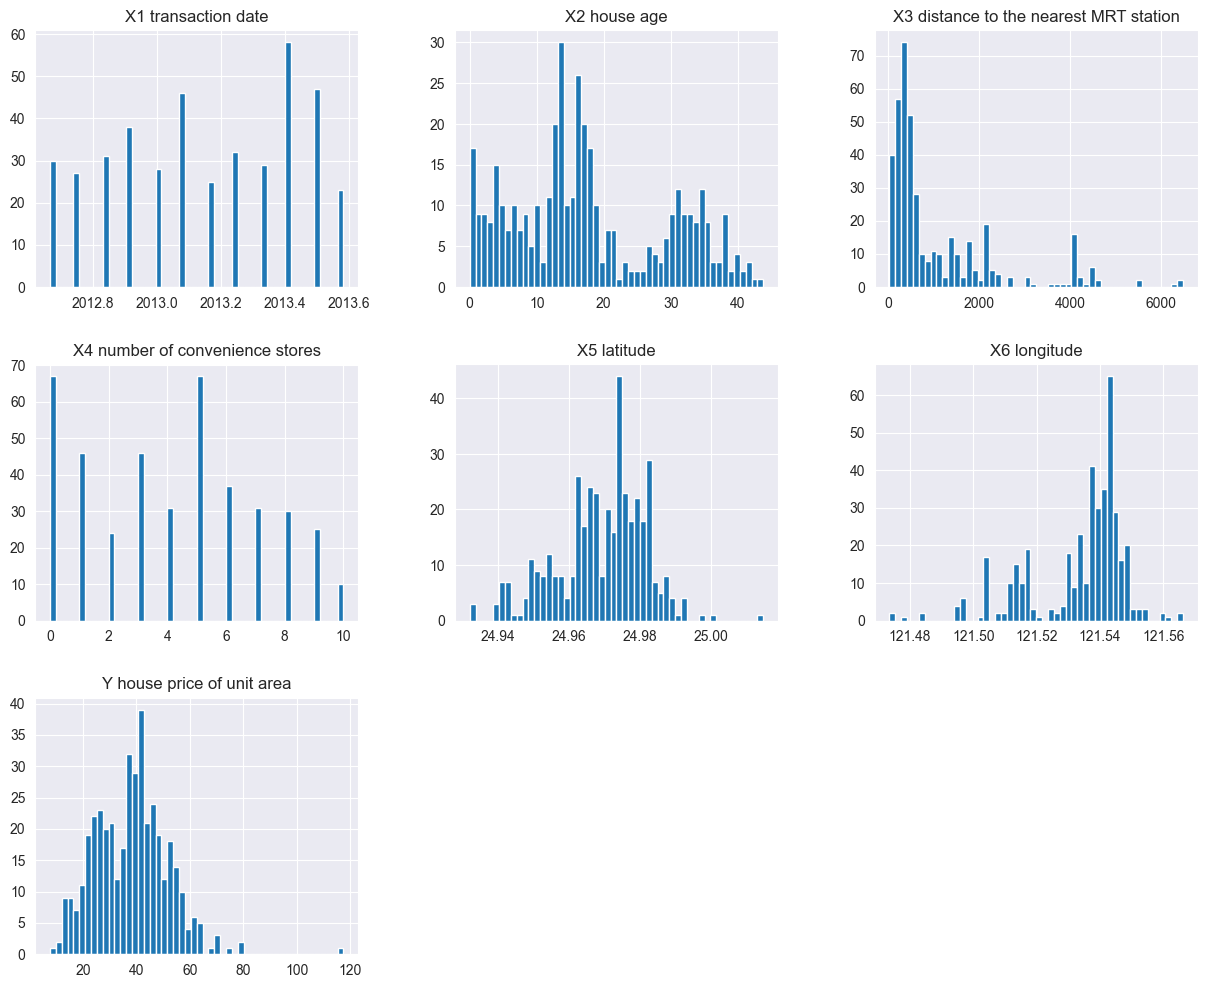

In [38]:
df_combined.hist(bins=50, figsize=[15,12]);

Данные

## 4.4 Modeling

## 4.5 Evaluation

## 4.6 Deployment